This notebook compiles the features we have collected, and trains several ML models to predict a film's average IMDB rating from them. 

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
# !pip install shap

In [2]:
# load in CSVs
# first is youtube trailer links; second is IMDB ids for those movies
# third is their average ratings and num votes
# fourth is basic film metadata
youtubeIDs = pd.read_csv('/Volumes/GoogleDrive/My Drive/ml-youtube.csv') # https://grouplens.org/datasets/movielens/20m-youtube/
links = pd.read_csv('/Volumes/GoogleDrive/My Drive/movies_dataset_links.csv') # http://files.grouplens.org/datasets/movielens/ml-20m-README.html
titleRatings = pd.read_csv('/Volumes/GoogleDrive/My Drive/title.ratings.tsv', sep='\t', usecols = ['tconst', 'numVotes', 'averageRating']) # https://datasets.imdbws.com/
titleRatings['tconst'] = titleRatings['tconst'].str[2:].astype(int)
titleBase = pd.read_csv('/Volumes/GoogleDrive/My Drive/title.basics.tsv', sep='\t', usecols = ['tconst', 'runtimeMinutes', 'genres']) # https://datasets.imdbws.com/
titleBase['tconst'] = titleBase['tconst'].str[2:].astype(int)

# merge them together
yt_links = pd.merge(youtubeIDs, links, on = 'movieId')
yt_links_ratings = pd.merge(yt_links, titleRatings, left_on='imdbId', right_on = 'tconst') 
final = pd.merge(yt_links_ratings, titleBase, left_on='tconst', right_on = 'tconst')
final = final[(final['numVotes'] > 5000) & (final['runtimeMinutes'].str.replace("\\N", "-1", regex = False).astype(int) > 40)]

In [3]:
titleRatings

tconst  averageRating  numVotes
0             1            5.6      1546
1             2            6.1       187
2             3            6.5      1203
3             4            6.2       114
4             5            6.1      1928
...         ...            ...       ...
988225  9916576            5.9         7
988226  9916578            9.1        11
988227  9916720            5.1        41
988228  9916766            6.7        11
988229  9916778            6.9        16

[988230 rows x 3 columns]

In [4]:
final[]

youtubeId  movieId                               title   imdbId  \
0      K26_sDKnvMU        1                    Toy Story (1995)   114709   
1      3LPANjHlPxo        2                      Jumanji (1995)   113497   
2      rEnOoWs3FuA        3             Grumpier Old Men (1995)   113228   
3      j9xml1CxgXI        4            Waiting to Exhale (1995)   114885   
4      ltwvKLnj1B4        5  Father of the Bride Part II (1995)   113041   
...            ...      ...                                 ...      ...   
25540  uyknfocH8t4   131170                    Parallels (2015)  3479316   
25543  yDQ7mX3SA80   131176              A Second Chance (2014)  3305316   
25544  XIeBTqqSwbA   131180      Dead Rising: Watchtower (2015)  3816458   
25546  LXBkjw0wojk   131237          What Men Talk About (2010)  1595366   
25550  BHCLOiotTA8   131248               Brother Bear 2 (2006)   465925   

         tmdbId   tconst  averageRating  numVotes runtimeMinutes  \
0         862.0   114709            8.3    820970             81   
1        8844.0   113497            7.0    277681            104   
2       15602.0   113228            6.7     22766            101   
3       31357.0   114885            5.9      8910            124   
4       11862.0   113041            6.0     31988            106   
...         ...      ...            ...       ...            ...   
25540  328595.0  3479316            6.1     12984             83   
25543  254200.0  3305316            6.8      5165            102   
25544  293771.0  3816458            5.2      7872            118   
25546   35428.0  1595366            7.6      5044             93   
25550   10010.0   465925            6.2     13041             74   

                           genres  
0      Adventure,Animation,Comedy  
1         Adventure,Comedy,Family  
2                  Comedy,Romance  
3            Comedy,Drama,Romance  
4           Comedy,Family,Romance  
...                           ...  
25540               Action,Sci-Fi  
25543              Drama,Thriller  
25544               Action,Horror  
25546                      Comedy  
25550  Adventure,Animation,Comedy  

[10068 rows x 10 columns]

Prosody Features

In [5]:
prosody_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/mean_prosody_df.csv')

In [16]:
# one hot encode genres
ml = pd.merge(final[['youtubeId', 'title', 'genres', 'averageRating', 'imdbId']], prosody_df, how = 'inner', left_on = 'youtubeId', right_on = 'youtubeId')
ml['genres'] = ml['genres'].str.split(',')
mlb = MultiLabelBinarizer()
ml = ml.join(pd.DataFrame(mlb.fit_transform(ml.pop('genres')),
                          columns=mlb.classes_,
                          index=ml.index))


# LIWC Feature Extraction


In [17]:
liwc_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/liwc/new_combined_LIWC.csv', encoding = "ISO-8859-1")
liwc_df = liwc_df.drop(columns=['Source (A)', 'Source (C)']).rename(columns={"Source (B)": "youtubeId"})
liwc_features = set(liwc_df.columns)

# OPENSMILE Feature Extraction


In [18]:
opensmile_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/opensmile/output.csv', encoding = "ISO-8859-1")
opensmile_df['youtubeId'] = opensmile_df['name'].apply(lambda x: x.split('_00')[0].replace('no_music_', '').replace("'", ''))
opensmile_features = set(opensmile_df.columns)
opensmile_df = opensmile_df.groupby('youtubeId', as_index= False).mean()

# PRAAT Feature Extraction

In [19]:
praat_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/praat/praat.csv', encoding = "ISO-8859-1", header= None, names = ['filename', 'Min Pitch', 'Max Pitch', 'Mean Pitch', 'Sd Pitch',
       'Min Intensity', 'Max Intensity', 'Mean Intensity', 'Sd Intensity',
       'Jitter', 'Shimmer', 'HNR', 'Energy'] )
praat_df['youtubeId'] = praat_df['filename'].apply(lambda x: x.split('_00')[0].replace('no_music_', ''))
praat_features = set(praat_df.columns)
praat_df = praat_df.groupby('youtubeId', as_index= False).mean()

# Low Level Features (Spectral Rolloff, Spectral Flux) and Chroma

In [20]:
spectral_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/spectral.csv', encoding = "ISO-8859-1" )
features_keep = ['youtubeId'] + [x for x in spectral_df.columns if ('spectralRollOff' in x or 'spectralFlux' in x) and ('maxPos' in x or 'stddev' in x or '_amean' in x)]

In [21]:
# spectral_df = spectral_df.drop(columns=['Unnamed: 0'])
y_id = [yid[1:] for yid in spectral_df['youtubeId'].tolist()]

spectral_df = spectral_df[features_keep]
spectral_df['youtubeId'] = y_id
spectral_features = set(spectral_df.columns)

In [22]:
chroma_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/chroma_features.csv', encoding = "ISO-8859-1")
chroma_df = chroma_df.drop(columns=['Unnamed: 0'])
chroma_features = set(chroma_df.columns)

# Merge LIWC, Opensmile, Praat

In [23]:
df1 = pd.merge(opensmile_df, liwc_df)
df2 = pd.merge(praat_df, df1, on = 'youtubeId')
df3 = pd.merge(chroma_df, df2, on='youtubeId')
df4 = pd.merge(spectral_df, df3, on='youtubeId')
ml = pd.merge(ml, df4, on= "youtubeId")

# Add rotten tomato ranking

In [91]:
import pickle
with open("/Volumes/GoogleDrive/My Drive/feature_extraction/omdb.pkl", "rb") as f:
    d = pickle.load(f)
rotten_score = []
meta_score = []
for imdb_id in ["tt{:07d}".format(imdb_id) for imdb_id in list(ml['imdbId'])]:
    omdb_dict = d[imdb_id]
    score = [x['value'].rstrip("%") for x in omdb_dict['ratings'] if x['source'] == 'Rotten Tomatoes'] 
    metascore = omdb_dict['metascore']
    if metascore == 'N/A':
        meta_score.append(None)
    else:
        meta_score.append(int(metascore))
    if len(score) == 1:
        rotten_score.append(int(score[0]))
    else:
        rotten_score.append(None)
ml['metascore'] = meta_score

In [92]:
ml = ml.dropna()

Text(0.5, 0, 'Metascore Rating')

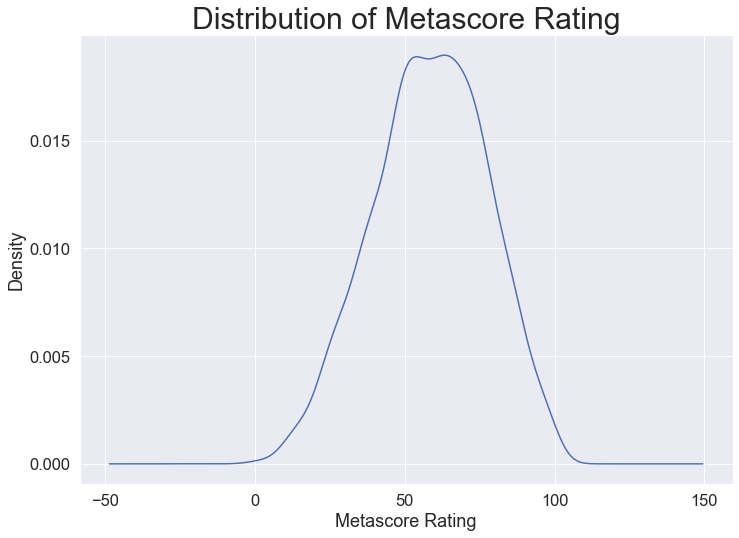

In [326]:
ml['metascore'].plot(kind = 'kde')
sns.set(font_scale=2.5)
plt.title('Distribution of Metascore Rating')
plt.xlabel('Metascore Rating')

In [285]:
ml['metascore'].mean(), ml['metascore'].std()

(58.42318982387476, 18.876689025022507)

In [93]:
len(ml)

2044

In [280]:
for g in genres:
    print(g, len(ml[ml[g] == 1]))

Action 419
Adventure 317
Animation 79
Biography 122
Comedy 778
Crime 396
Documentary 30
Drama 1124
Family 107
Fantasy 144
Film-Noir 8
History 51
Horror 213
Music 74
Musical 25
Mystery 191
Romance 390
Sci-Fi 159
Sport 51
Thriller 349
War 48
Western 34


In [94]:
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
          'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
          'Thriller', 'War', 'Western']

In [95]:
ml.pop('averageRating')

1       7.0
2       7.0
3       8.3
4       8.3
5       6.7
       ... 
2653    5.8
2654    6.0
2655    5.7
2656    6.1
2657    5.8
Name: averageRating, Length: 2044, dtype: float64

# Train Test Split

In [96]:
text_youtube = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/liwc/new_combined.csv', 
                           encoding = "ISO-8859-1",
                           index_col=[0])
ml = pd.merge(ml, text_youtube, left_on= "youtubeId", right_on="audio_fn")

In [97]:
# train test split
y = ml['metascore']#ml['averageRating']
X = ml.drop(columns=['metascore', 'audio_fn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
train_texts = X_train['text']
test_texts = X_test['text']
# ml.pop('text')

In [99]:
# X_train = X_train.drop(columns=genres)
# X_test = X_test.drop(columns = genres)

# Train Linear Model

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vect = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(1, 3), max_features=100)
tf_train = tf_vect.fit_transform(train_texts.tolist())
tf_test = tf_vect.transform(test_texts.tolist())
tf_train_df = pd.DataFrame(tf_train.toarray())
tf_test_df = pd.DataFrame(tf_test.toarray())

tf_train_df.reset_index(drop=True)
tf_test_df.reset_index(drop=True)
X_train.head()

X_train_lm = pd.concat([X_train.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = 1)
X_test_lm = pd.concat([X_test.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = 1)
X_train_lm = X_train_lm.drop(columns=['text'])
X_test_lm = X_test_lm.drop(columns=['text'])

In [101]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

lasso = Lasso(random_state=0, max_iter=10000)
alphas =np.arange(0.1, 1.1, 0.1)

tuned_parameters = [{'alpha': alphas}]
lm_clf = GridSearchCV(lasso, tuned_parameters, cv=3, refit=True)
scaler = StandardScaler()
X_train_lasso = scaler.fit_transform(X_train_lm.loc[:, 'embed0':].drop(columns=genres))
X_test_lasso = scaler.transform(X_test_lm.loc[:, 'embed0':].drop(columns=genres))
grid_result = lm_clf.fit(X_train_lasso, y_train)
best_params = grid_result.best_params_

In [102]:
best_params

{'alpha': 0.7000000000000001}

Text(0, 0.5, 'Density')

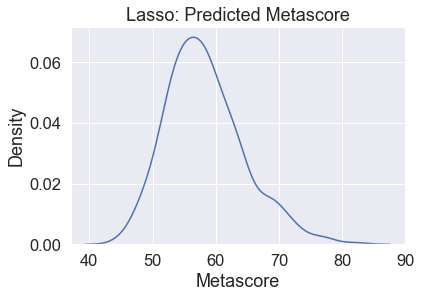

In [302]:
sns.kdeplot(lm_clf.predict(X_test_lasso))
# plt.xticks([2* i for i in range(-1, 8)])
plt.title('Lasso: Predicted Metascore')
plt.xlabel('Metascore')
plt.ylabel('Density')

### Feature importance plots from linear model

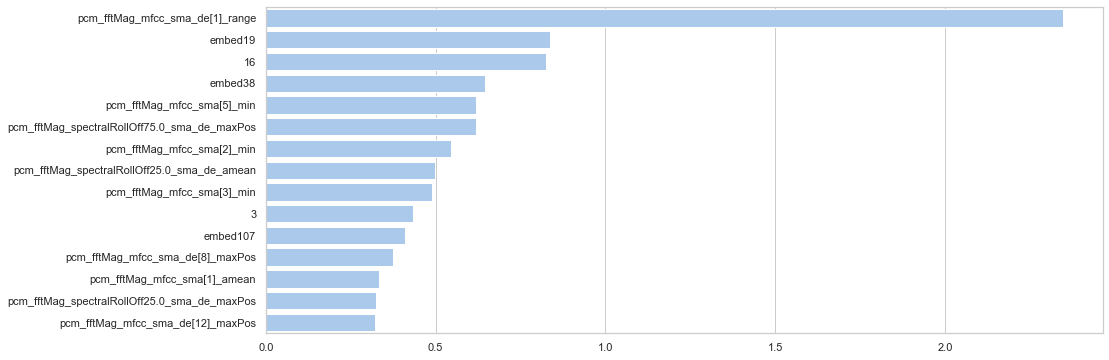

In [323]:
# TODO: feature importance plots from linear model

import seaborn as sns
import matplotlib.pyplot as plt
feat_impts = pd.Series(lm_clf.best_estimator_.coef_,
                       index = X_train_lm.loc[:, 'embed0':].drop(columns=genres).columns).sort_values(ascending = False).head(15)

# plot style
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25)
# Horizontal bar plot
sns.set_color_codes("pastel")
plot = sns.barplot(x=feat_impts.values, y=feat_impts.index,
            label="Feature Importances", color="b")

In [218]:
feat_impts = pd.Series(lm_clf.best_estimator_.coef_, index = X_train_lm.loc[:, 'embed0':].drop(columns=genres).columns).sort_values(ascending = False).head(15)
lm_feat = feat_impts.index
# plot style

In [105]:
feat_impts

pcm_fftMag_mfcc_sma_de[1]_range                 2.346313
embed19                                         0.837092
16                                              0.825816
embed38                                         0.644583
pcm_fftMag_mfcc_sma[5]_min                      0.620094
pcm_fftMag_spectralRollOff75.0_sma_de_maxPos    0.618617
pcm_fftMag_mfcc_sma[2]_min                      0.545209
pcm_fftMag_spectralRollOff25.0_sma_de_amean     0.499550
pcm_fftMag_mfcc_sma[3]_min                      0.490440
3                                               0.434216
embed107                                        0.411073
pcm_fftMag_mfcc_sma_de[8]_maxPos                0.375820
pcm_fftMag_mfcc_sma[1]_amean                    0.334834
pcm_fftMag_spectralRollOff25.0_sma_de_maxPos    0.324271
pcm_fftMag_mfcc_sma_de[12]_maxPos               0.320511
dtype: float64

In [106]:
tfidf_dict = {y:x for x,y in tf_vect.vocabulary_.items()} 
tfidf_dict[99]

'youre'

In [107]:
# TODO: regression performance plots, split on genre
# MAE, MAPE, stddev of each 
# seaborn kernel density estimate plots, if they're not too bad

# overall
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
  print(func.__qualname__, func(y_test, lm_clf.predict(X_test_lasso)))

print('standard deviation absolute error:',np.abs(y_test - lm_clf.predict(X_test_lasso)).std())


explained_variance_score 0.12234012679204598
max_error 50.80319242507008
mean_absolute_error 14.94303080715531
mean_squared_error 328.5172910621475
median_absolute_error 14.725797863613643
r2_score 0.11704675450187962
standard deviation absolute error: 10.270395375340037


In [108]:
y.std()

18.876689025022507

In [109]:
X_test_lm[X_test_lm['Action'] == 1]

youtubeId                              title   imdbId    embed0  \
2    IJ7AXKWmWOg         Grosse Pointe Blank (1997)   119229 -0.000299   
9    3pdPOqN06ec          Executive Decision (1996)   116253 -0.032532   
15   YOol44WGats  Mad Max Beyond Thunderdome (1985)    89530  0.135331   
19   K_4B9qa_iM0      War of the Worlds, The (1953)    46534  0.014235   
20   Y3iEgKjh3Nk                   Tank Girl (1995)   114614 -0.195568   
..           ...                                ...      ...       ...   
386  quHQAuO0lkg             Licence to Kill (1989)    97742  0.008542   
389  nRYp3LPL0bc                  Dreamscape (1984)    87175  0.001716   
393  LSHAgmGR-Ig                      Aliens (1986)    90605  0.375240   
402  Q48g1ijnSlI          Dying of the Light (2014)  1274586  0.043645   
404  86janCeyCdg               Patriot Games (1992)   105112 -0.052155   

       embed1    embed2    embed3    embed4    embed5    embed6  ...  \
2    0.173396 -0.527028 -0.040389  0.148683  0.171958  0.282589  ...   
9    0.158501 -0.300894 -0.038902  0.165618  0.139266  0.269604  ...   
15   0.113369 -0.036653 -0.067481  0.179720  0.274405  0.151553  ...   
19   0.037719 -0.695154  0.027117  0.291295 -0.156512  0.007034  ...   
20   0.112508 -0.466514  0.013174  0.180416 -0.012074  0.042502  ...   
..        ...       ...       ...       ...       ...       ...  ...   
386  0.120715 -0.244812  0.081577  0.253698 -0.101733  0.226190  ...   
389  0.066303 -0.312940  0.034552 -0.124872  0.096234  0.200639  ...   
393  0.054087 -0.256391  0.074514  0.353803 -0.163793  0.281674  ...   
402  0.082174 -0.373256 -0.032045  0.267656 -0.124531  0.109614  ...   
404 -0.003414 -0.340891  0.061887  0.272493 -0.030927  0.073151  ...   

           90        91        92   93   94        95        96        97  \
2    0.291549  0.000000  0.000000  0.0  0.0  0.150789  0.000000  0.479846   
9    0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.328454   
15   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
19   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
20   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
..        ...       ...       ...  ...  ...       ...       ...       ...   
386  0.000000  0.000000  0.233985  0.0  0.0  0.000000  0.000000  0.293733   
389  0.239209  0.165281  0.000000  0.0  0.0  0.000000  0.191218  0.157481   
393  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
402  0.000000  0.324758  0.000000  0.0  0.0  0.000000  0.000000  0.464149   
404  0.000000  0.000000  0.302312  0.0  0.0  0.000000  0.000000  0.126502   

           98        99  
2    0.000000  0.000000  
9    0.000000  0.000000  
15   0.000000  0.000000  
19   0.000000  0.000000  
20   0.000000  0.000000  
..        ...       ...  
386  0.000000  0.000000  
389  0.129097  0.000000  
393  0.000000  0.311617  
402  0.000000  0.000000  
404  0.000000  0.000000  

[80 rows x 800 columns]

In [110]:
# performance by genre
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
          'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
          'Thriller', 'War', 'Western']
y_test = y_test.reset_index(drop = True)
genre_perf_dict = {}
for genre in genres:
  genre_idx_list = X_test_lm[X_test_lm[genre] == 1].index.to_list()
  mask = X_test_lasso[genre_idx_list]
  genre_perf_dict[genre] = {}
  genre_perf_dict[genre]['num_movies'] = mask.shape[0]
  for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
    genre_perf_dict[genre][func.__qualname__] = func(y_test[genre_idx_list], lm_clf.predict(mask))

genre_perf_df = pd.DataFrame(genre_perf_dict).T.sort_values(by = 'num_movies', ascending = False)

/Users/sujipark/.local/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [111]:
genre_perf_df

num_movies  explained_variance_score  max_error  \
Drama             234.0                  0.115356  44.130860   
Comedy            145.0                  0.145420  42.172565   
Action             80.0                 -0.134513  50.803192   
Romance            80.0                  0.179727  40.738197   
Crime              78.0                  0.195702  38.106060   
Thriller           77.0                  0.116576  44.419929   
Adventure          55.0                 -0.141706  50.803192   
Horror             48.0                  0.125685  50.803192   
Sci-Fi             39.0                  0.189298  35.636856   
Mystery            35.0                  0.224172  44.419929   
Biography          32.0                  0.025593  39.131162   
Fantasy            22.0                 -0.123581  48.455195   
Music              16.0                 -0.069899  36.849073   
Sport              13.0                  0.356484  26.199062   
Family             10.0                  0.201579  35.743426   
Western             9.0                  0.211500  30.492748   
Animation           9.0                 -0.113470  29.411162   
Documentary         8.0                  0.378124  19.528659   
History             7.0                 -0.518906  28.652041   
Musical             6.0                 -0.530638  40.738197   
War                 6.0                  0.358868  28.055084   
Film-Noir           1.0                  1.000000  25.544109   

             mean_absolute_error  mean_squared_error  median_absolute_error  \
Drama                  15.368747          333.232069              15.736071   
Comedy                 15.319475          331.913034              15.695047   
Action                 14.624353          340.135847              10.429527   
Romance                14.422293          310.410648              14.344373   
Crime                  13.641792          254.695185              14.011884   
Thriller               14.662031          328.024786              15.153842   
Adventure              15.374294          368.790620              13.512821   
Horror                 15.183150          367.501439              13.731010   
Sci-Fi                 14.894266          312.817775              13.632304   
Mystery                14.558905          326.521030              13.632304   
Biography              14.985309          320.738047              14.848067   
Fantasy                17.851604          468.825439              14.797864   
Music                  18.943643          481.026080              18.535100   
Sport                  10.101684          153.863330               9.236301   
Family                 13.839687          258.365047              11.108306   
Western                12.311811          255.016861               5.763725   
Animation              14.099367          270.030060              11.277942   
Documentary            10.046808          127.984381               8.215843   
History                21.968406          497.109932              22.661852   
Musical                22.609685          679.908119              20.600923   
War                    13.456251          288.908015               8.538208   
Film-Noir              25.544109          652.501509              25.544109   

             r2_score  
Drama        0.051633  
Comedy       0.137851  
Action      -0.240863  
Romance      0.174755  
Crime        0.173469  
Thriller     0.080660  
Adventure   -0.143957  
Horror      -0.047304  
Sci-Fi       0.188986  
Mystery      0.223390  
Biography   -1.360063  
Fantasy     -0.185337  
Music       -0.074956  
Sport        0.350220  
Family       0.192710  
Western      0.009857  
Animation   -0.376144  
Documentary -0.537639  
History     -1.843613  
Musical     -5.168521  
War         -0.092395  
Film-Noir         NaN

In [118]:
genre_perf_df.to_csv('/Volumes/GoogleDrive/My Drive/slp2019/metascore_genre_perf_df_lasso.csv')

Text(0.5, 1.0, 'Lasso: Distribution of errors (Actual vs. Predicted Metascore)')

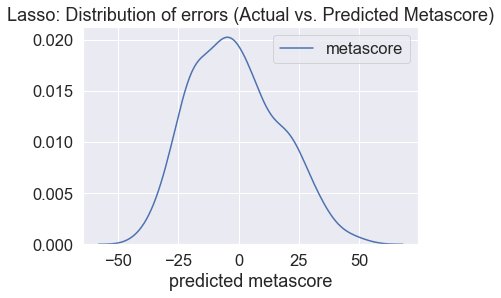

In [301]:
# distribution of errors
sns.kdeplot(lm_clf.predict(X_test_lasso) - y_test
              # color="g"
              )
plt.xlabel('predicted metascore')
plt.title('Lasso: Distribution of errors (Actual vs. Predicted Metascore)')

In [202]:
# distribution of errors by genre
errs_df = np.concatenate([X_test[genres].values,
                          y_test.values.reshape(-1,1),
                          lm_clf.predict(X_test_lasso).reshape(-1,1)], axis = 1)
errs_df = pd.DataFrame(errs_df, columns = genres + ['metascore', 'pred_metascore'])

In [203]:

errs_by_genre = errs_df.apply(lambda row: np.dot(row[genres].values, np.abs(row['metascore'] - row['pred_metascore'])), axis = 1)
# errs_by_genre_df = pd.DataFrame.from_dict(zip(errs_by_genre.index, errs_by_genre.values)).T
errs_by_genre_df = pd.DataFrame(zip(*errs_by_genre.values)).T
errs_by_genre_df.columns = genres
errs_by_genre_df = errs_by_genre_df.replace(0, np.nan)

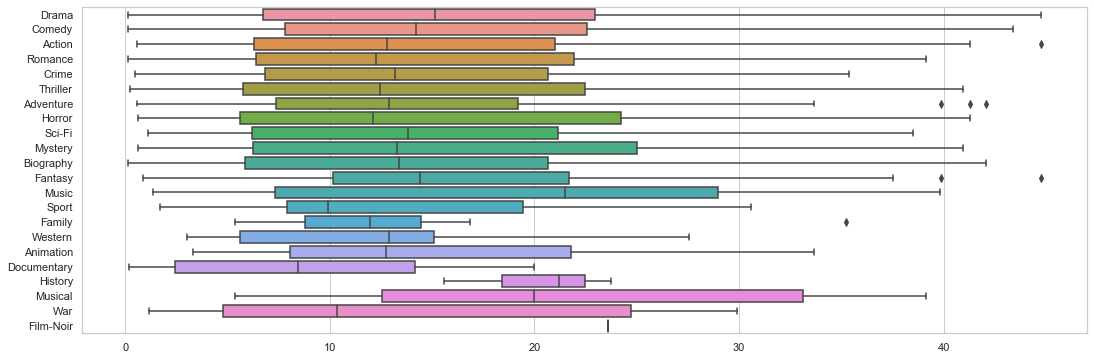

In [312]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
sns.boxplot(data=errs_by_genre_df, ax = ax, orient = 'h', order = genre_perf_df.index)

In [117]:
# genre_perf_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/slp2019/genre_perf_df_lasso.csv', index_col = [0])

# Train Random Forest

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_rf_all = X_train.drop(columns = ['youtubeId','title', 'text', 'imdbId']).drop(columns=genres)
X_test_rf_all = X_test.drop(columns = ['youtubeId','title', 'text', 'imdbId']).drop(columns=genres)
 
tf_vect = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(1, 3), max_features = 100)
tf_train = tf_vect.fit_transform(train_texts.tolist())
tf_test = tf_vect.transform(test_texts.tolist())
tf_train_df = pd.DataFrame(tf_train.toarray())
X_train_rf_all = pd.concat([X_train_rf_all.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = 1)
X_train_rf = X_train_rf_all

tf_test_df = pd.DataFrame(tf_test.toarray())
X_test_rf_all = pd.concat([X_test_rf_all.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = 1) 
X_test_rf = X_test_rf_all
X_test_rf.index = X_test.index

In [163]:
assert 'Drama' not in list(X_train_rf.columns)

In [164]:
# rf_feature_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/rf_feature_select.csv')
# features_keep = []
# for x in rf_feature_df['selected_feature_name'].tolist():
#     if x.isdigit():
#         features_keep.append(int(x))
#     else:
#         features_keep.append(x)
# features_keep
# X_train_rf = X_train_rf[features_keep]
# X_test_rf = X_test_rf[features_keep]

In [165]:
rf_params = {'bootstrap': [True, False],
            'max_depth': [40, 60, 80, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000]}
rf_clf = GridSearchCV(RandomForestRegressor(), rf_params, cv=3, n_jobs = -1)
grid_result = rf_clf.fit(X_train_rf, y_train)


In [166]:
best_params = grid_result.best_params_
print(best_params)

{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [167]:
pwd

'/Volumes/GoogleDrive/My Drive/Colab Notebooks'

In [168]:
import pickle
with open("/Volumes/GoogleDrive/My Drive/slp2019/metascore_grid_result.pkl", "wb") as f:
    pickle.dump(grid_result, f)

In [190]:
import pickle
with open("/Volumes/GoogleDrive/My Drive/slp2019/rf_clf_metascore.pkl", "wb") as f:
    pickle.dump(rf_clf, f)

### Feature importance plots from tree model

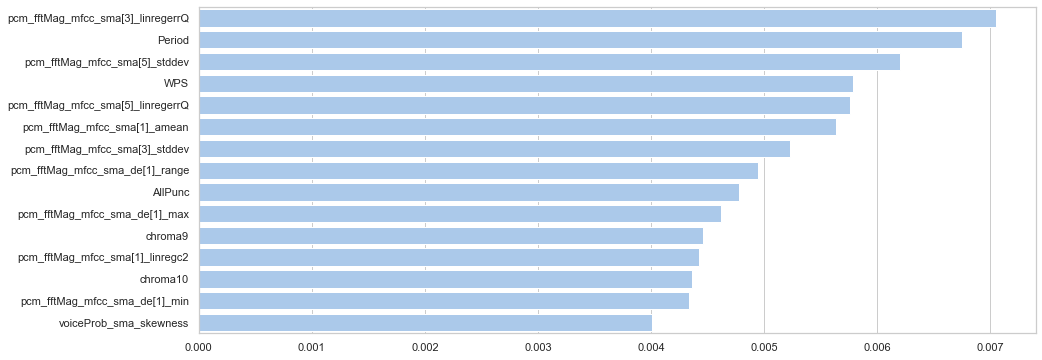

In [310]:
# TODO: feature importance plots from tree model

import seaborn as sns
import matplotlib.pyplot as plt

feat_impts = pd.Series(rf_clf.best_estimator_.feature_importances_,
                       index = X_train_rf.columns).sort_values(ascending = False).head(15)

# plot style
sns.set(font_scale=1.5)
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Horizontal bar plot
sns.set_color_codes("pastel")
plot = sns.barplot(x=feat_impts.values, y=feat_impts.index,
            label="Feature Importances", color="b")

In [171]:
list(X_train_rf.columns)

['embed0',
 'embed1',
 'embed2',
 'embed3',
 'embed4',
 'embed5',
 'embed6',
 'embed7',
 'embed8',
 'embed9',
 'embed10',
 'embed11',
 'embed12',
 'embed13',
 'embed14',
 'embed15',
 'embed16',
 'embed17',
 'embed18',
 'embed19',
 'embed20',
 'embed21',
 'embed22',
 'embed23',
 'embed24',
 'embed25',
 'embed26',
 'embed27',
 'embed28',
 'embed29',
 'embed30',
 'embed31',
 'embed32',
 'embed33',
 'embed34',
 'embed35',
 'embed36',
 'embed37',
 'embed38',
 'embed39',
 'embed40',
 'embed41',
 'embed42',
 'embed43',
 'embed44',
 'embed45',
 'embed46',
 'embed47',
 'embed48',
 'embed49',
 'embed50',
 'embed51',
 'embed52',
 'embed53',
 'embed54',
 'embed55',
 'embed56',
 'embed57',
 'embed58',
 'embed59',
 'embed60',
 'embed61',
 'embed62',
 'embed63',
 'embed64',
 'embed65',
 'embed66',
 'embed67',
 'embed68',
 'embed69',
 'embed70',
 'embed71',
 'embed72',
 'embed73',
 'embed74',
 'embed75',
 'embed76',
 'embed77',
 'embed78',
 'embed79',
 'embed80',
 'embed81',
 'embed82',
 'embed83',
 'embed84',
 'embed85',
 'embed86',
 'embed87',
 'embed88',
 'embed89',
 'embed90',
 'embed91',
 'embed92',
 'embed93',
 'embed94',
 'embed95',
 'embed96',
 'embed97',
 'embed98',
 'embed99',
 'embed100',
 'embed101',
 'embed102',
 'embed103',
 'embed104',
 'embed105',
 'embed106',
 'embed107',
 'embed108',
 'embed109',
 'embed110',
 'embed111',
 'embed112',
 'embed113',
 'embed114',
 'embed115',
 'embed116',
 'embed117',
 'embed118',
 'embed119',
 'embed120',
 'embed121',
 'embed122',
 'embed123',
 'embed124',
 'embed125',
 'embed126',
 'embed127',
 'News',
 'pcm_fftMag_spectralRollOff25.0_sma_maxPos',
 'pcm_fftMag_spectralRollOff25.0_sma_stddev',
 'pcm_fftMag_spectralRollOff25.0_sma_amean',
 'pcm_fftMag_spectralRollOff50.0_sma_maxPos',
 'pcm_fftMag_spectralRollOff50.0_sma_stddev',
 'pcm_fftMag_spectralRollOff50.0_sma_amean',
 'pcm_fftMag_spectralRollOff75.0_sma_maxPos',
 'pcm_fftMag_spectralRollOff75.0_sma_stddev',
 'pcm_fftMag_spectralRollOff75.0_sma_amean',
 'pcm_fftMag_spectralRollOff90.0_sma_maxPos',
 'pcm_fftMag_spectralRollOff90.0_sma_stddev',
 'pcm_fftMag_spectralRollOff90.0_sma_amean',
 'pcm_fftMag_spectralFlux_sma_maxPos',
 'pcm_fftMag_spectralFlux_sma_stddev',
 'pcm_fftMag_spectralFlux_sma_amean',
 'pcm_fftMag_spectralRollOff25.0_sma_de_maxPos',
 'pcm_fftMag_spectralRollOff25.0_sma_de_stddev',
 'pcm_fftMag_spectralRollOff25.0_sma_de_amean',
 'pcm_fftMag_spectralRollOff50.0_sma_de_maxPos',
 'pcm_fftMag_spectralRollOff50.0_sma_de_stddev',
 'pcm_fftMag_spectralRollOff50.0_sma_de_amean',
 'pcm_fftMag_spectralRollOff75.0_sma_de_maxPos',
 'pcm_fftMag_spectralRollOff75.0_sma_de_stddev',
 'pcm_fftMag_spectralRollOff75.0_sma_de_amean',
 'pcm_fftMag_spectralRollOff90.0_sma_de_maxPos',
 'pcm_fftMag_spectralRollOff90.0_sma_de_stddev',
 'pcm_fftMag_spectralRollOff90.0_sma_de_amean',
 'pcm_fftMag_spectralFlux_sma_de_maxPos',
 'pcm_fftMag_spectralFlux_sma_de_stddev',
 'pcm_fftMag_spectralFlux_sma_de_amean',
 'pcm_fftMag_spectralRollOff25.0_sma_de_de_maxPos',
 'pcm_fftMag_spectralRollOff25.0_sma_de_de_stddev',
 'pcm_fftMag_spectralRollOff25.0_sma_de_de_amean',
 'pcm_fftMag_spectralRollOff50.0_sma_de_de_maxPos',
 'pcm_fftMag_spectralRollOff50.0_sma_de_de_stddev',
 'pcm_fftMag_spectralRollOff50.0_sma_de_de_amean',
 'pcm_fftMag_spectralRollOff75.0_sma_de_de_maxPos',
 'pcm_fftMag_spectralRollOff75.0_sma_de_de_stddev',
 'pcm_fftMag_spectralRollOff75.0_sma_de_de_amean',
 'pcm_fftMag_spectralRollOff90.0_sma_de_de_maxPos',
 'pcm_fftMag_spectralRollOff90.0_sma_de_de_stddev',
 'pcm_fftMag_spectralRollOff90.0_sma_de_de_amean',
 'pcm_fftMag_spectralFlux_sma_de_de_maxPos',
 'pcm_fftMag_spectralFlux_sma_de_de_stddev',
 'pcm_fftMag_spectralFlux_sma_de_de_amean',
 'chroma1',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chroma10',
 'chroma11',
 'chroma12',
 'Min Pitch',
 'Max Pitch',
 'Mean Pitch',
 'Sd Pitch',
 'Min Intensity',
 'Max Intensity',
 'Mean Intensity',
 'Sd Intensity',
 'Jitter',
 'Shimmer',
 'HNR',
 'En

In [172]:
# exploration of embed4

# performance by genre
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
          'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
          'Thriller', 'War', 'Western']

genre_embed4 = {}
for genre in genres:
  mask = X_test[X_test[genre] == 1][['embed4']]
  genre_embed4[genre] = {}
  genre_embed4[genre]['embed4_mean'] = mask['embed4'].mean()
  genre_embed4[genre]['embed4_std'] = mask['embed4'].std()
  genre_embed4[genre]['num_movies'] = mask.shape[0]

genre_embed4 = pd.DataFrame(genre_embed4).T.sort_values(by = 'embed4_mean', ascending = False)
genre_embed4[genre_embed4['num_movies'] > 25].head()

embed4_mean  embed4_std  num_movies
Comedy        0.217263    0.183642       145.0
Crime         0.159097    0.199895        78.0
Sci-Fi        0.150970    0.161578        39.0
Adventure     0.150762    0.173306        55.0
Drama         0.146576    0.164947       234.0

In [173]:
X_test.nlargest(5, ['embed4'])[['youtubeId', 'title']]

youtubeId                   title
251   kgh27gCgiQw   Drop Dead Fred (1991)
422   dl4r6JK6vgY          Flubber (1997)
1544  qz6RreTMEyA   All or Nothing (2002)
1244  ZFeyf3NwHPc  Dream Team, The (1989)
1364  cRz9axkehgU     Servant, The (1963)

In [174]:
# video clips that are not trailers are in the dataset!
# unfortunate, but it lets us understand that embedding 4 encodes
# something related to the intensity of the audio (high embed4 = high intensity)
# and perhaps some element of emotion, too 
X_test.nsmallest(8, ['embed4'])[['youtubeId', 'title']]

youtubeId                       title
203   zaC2bWF60A8   To Be or Not to Be (1942)
1425  7cJRLGsmRLc  Rashomon (Rashômon) (1950)
1856  knKkCl6Tys0               Exists (2014)
1859  2dEWuatLKGw           Guest, The (2014)
298   yGQm50DTOVk           Unforgiven (1992)
196   4oHrxHqLdd8        Roman Holiday (1953)
1599  HdqQnkrNy7s         Mr. Majestyk (1974)
1532  NfrKfRu1tFQ    Absence of Malice (1981)

In [175]:
# TODO: regression performance plots, split on genre
# MAE, MAPE, stddev of each 
# seaborn kernel density estimate plots, if they're not too bad

# overall
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
  print(func.__qualname__, func(y_test, rf_clf.predict(X_test_rf[X_train_rf.columns])))

print('standard deviation absolute error:',np.abs(y_test - rf_clf.predict(X_test_rf[X_train_rf.columns])).std())


explained_variance_score 0.11590848261205233
max_error 44.77417857142857
mean_absolute_error 15.061956572359994
mean_squared_error 331.0762608580459
median_absolute_error 13.41378571428573
r2_score 0.11016903223917918
standard deviation absolute error: 10.221015158345503


In [176]:
y.std()

18.876689025022507

In [177]:
deep_y_test = y_test.copy(deep=True)
deep_y_test.index = X_test_rf.index

In [178]:
# performance by genre
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
          'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
          'Thriller', 'War', 'Western']

genre_perf_dict = {}
for genre in genres:
  mask = X_test_rf[X_test[genre] == 1]
  genre_perf_dict[genre] = {}
  genre_perf_dict[genre]['num_movies'] = mask.shape[0]
  for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
    genre_perf_dict[genre][func.__qualname__] = func(deep_y_test.loc[mask.index], rf_clf.predict(mask))

genre_perf_df = pd.DataFrame(genre_perf_dict).T.sort_values(by = 'num_movies', ascending = False)

/Users/sujipark/.local/lib/python3.7/site-packages/sklearn/metrics/regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Text(0, 0.5, 'Density')

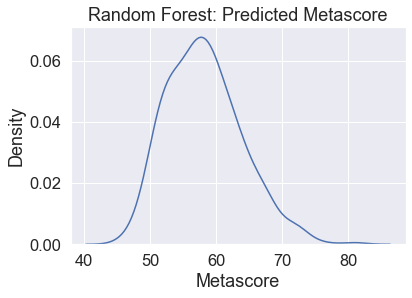

In [296]:
# genre_perf_df.to_csv('/content/gdrive/My Drive/genre_perf_df.csv')
sns.set(font_scale=1.5)
sns.kdeplot(rf_clf.predict(X_test_rf))
# plt.xticks([2* i for i in range(-1, 8)])
plt.title('Random Forest: Predicted Metascore')
plt.xlabel('Metascore')
plt.ylabel('Density')

Text(0.5, 1.0, 'Random Forest: Distribution of errors (Actual vs. Predicted Metascore)')

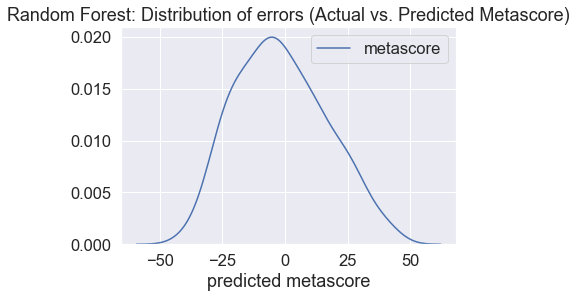

In [300]:
# distribution of errors
sns.kdeplot(rf_clf.predict(X_test_rf[X_train_rf.columns]) - y_test
              # color="g"
              )
plt.xlabel('predicted metascore')
plt.title('Random Forest: Distribution of errors (Actual vs. Predicted Metascore)')


In [205]:
# distribution of errors by genre
errs_df = np.concatenate([X_test[genres].values,
                          y_test.values.reshape(-1,1),
                          rf_clf.predict(X_test_rf[X_train_rf.columns]).reshape(-1,1)], axis = 1)
errs_df = pd.DataFrame(errs_df, columns = genres + ['metascore', 'pred_metascore'])

In [206]:
errs_by_genre = errs_df.apply(lambda row: np.dot(row[genres].values, np.abs(row['metascore'] - row['pred_metascore'])), axis = 1)
errs_by_genre_df = pd.DataFrame.from_items(zip(errs_by_genre.index, errs_by_genre.values)).T
errs_by_genre_df.columns = genres
errs_by_genre_df = errs_by_genre_df.replace(0, np.nan)

/Users/sujipark/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


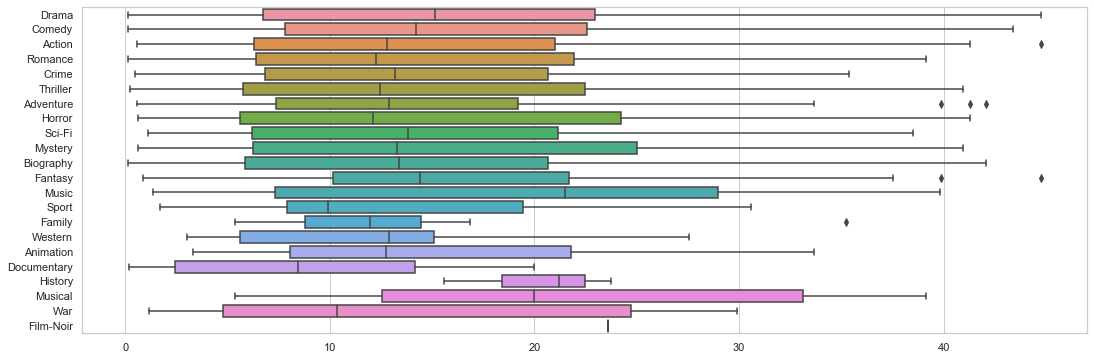

In [207]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
sns.boxplot(data=errs_by_genre_df, ax = ax, orient = 'h', order = genre_perf_df.index)

In [208]:
# TODO: merge in budget and analyze whether performance is a proxy for budget (for final paper)
# https://www.kaggle.com/rounakbanik/the-movies-dataset

Importances by Genre

In [209]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(rf_clf.best_estimator_)
shap_values = explainer.shap_values(X_test_rf)

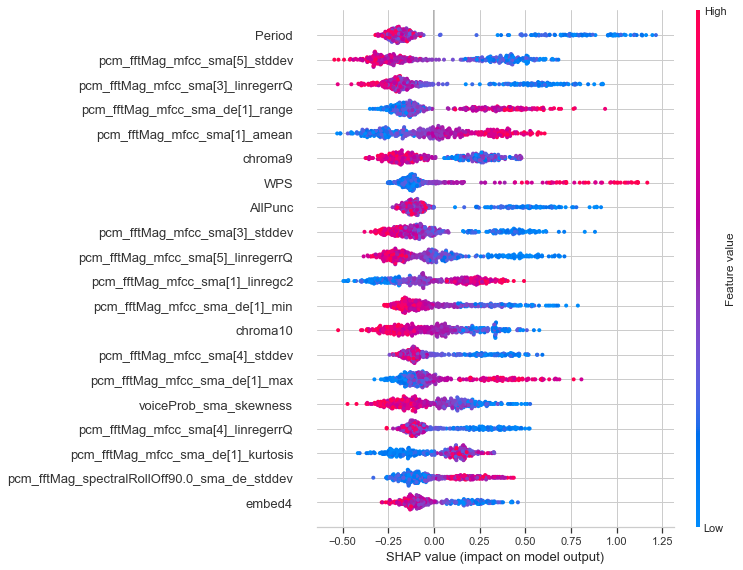

In [210]:
shap.summary_plot(shap_values, X_test_rf)

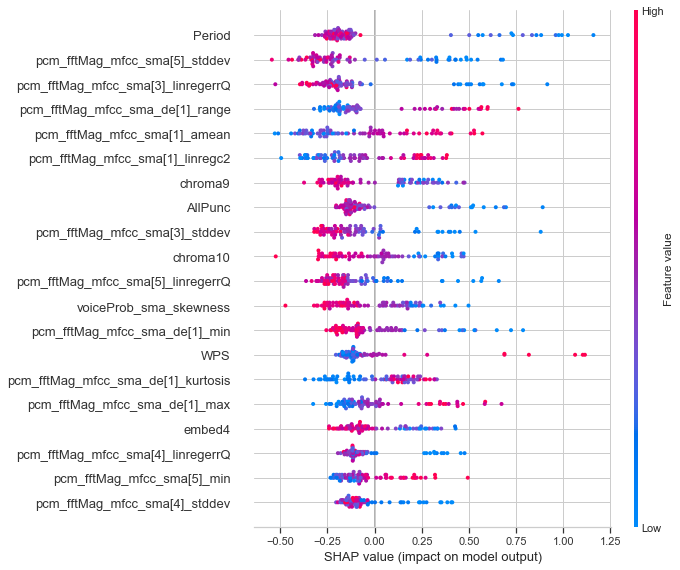

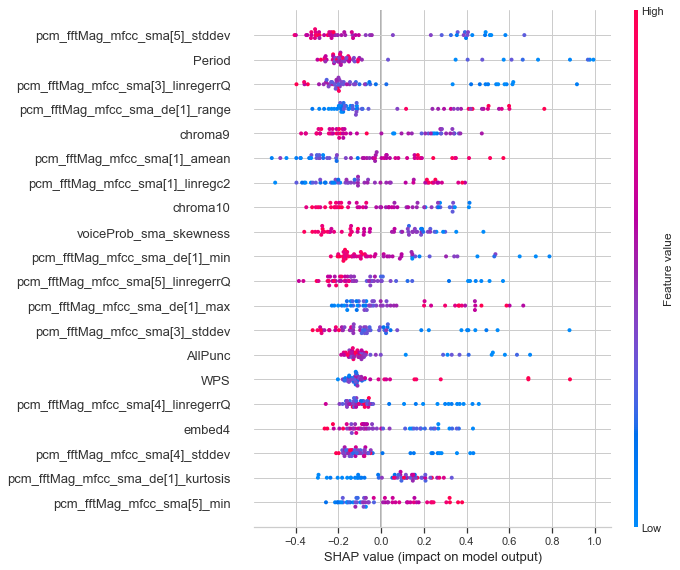

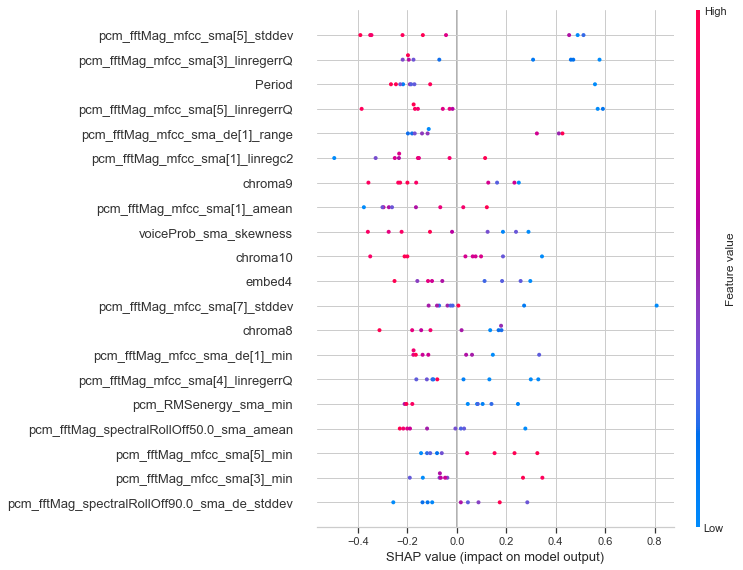

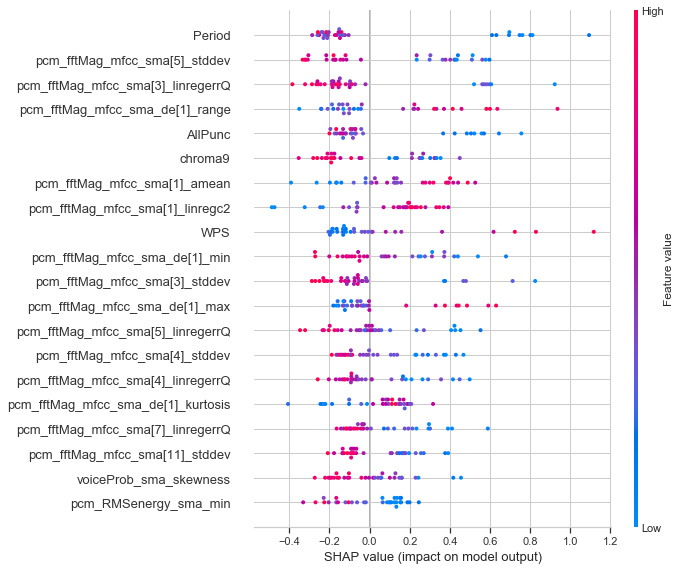

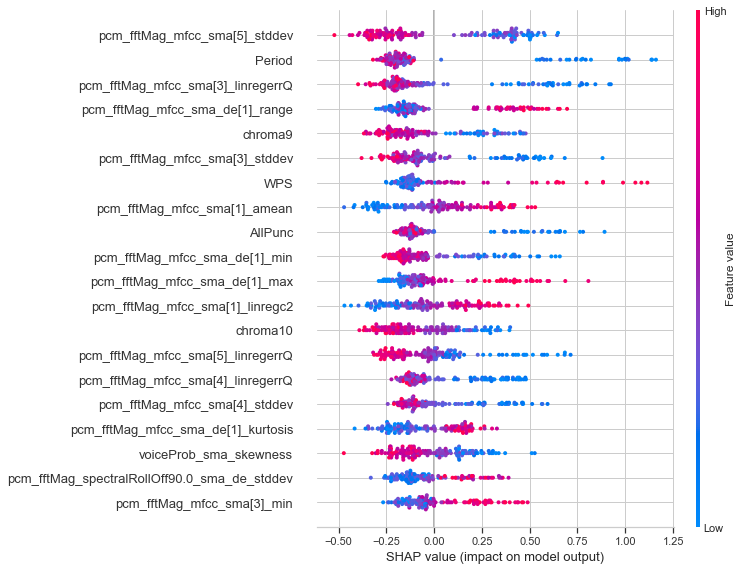

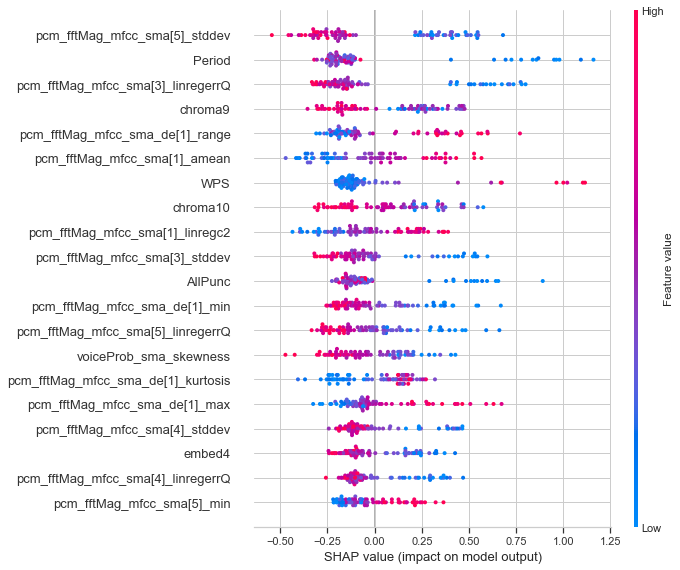

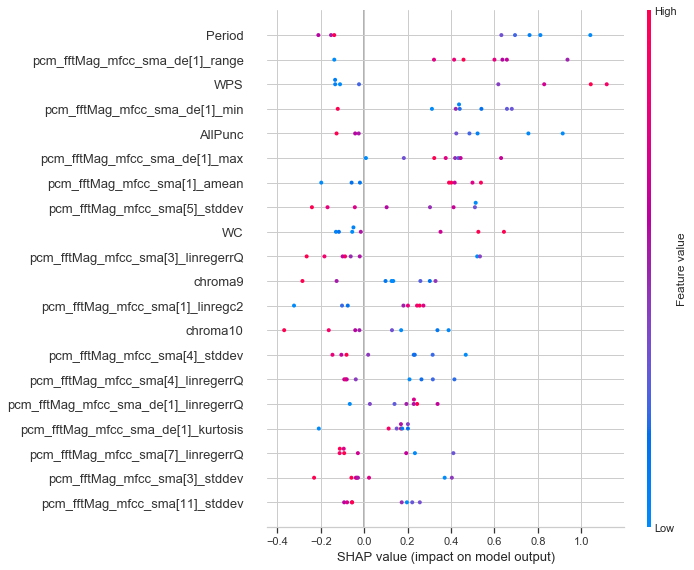

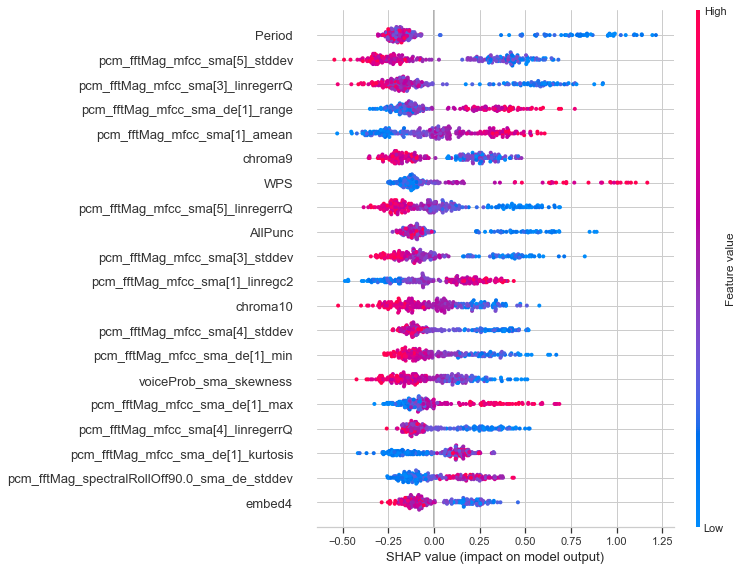

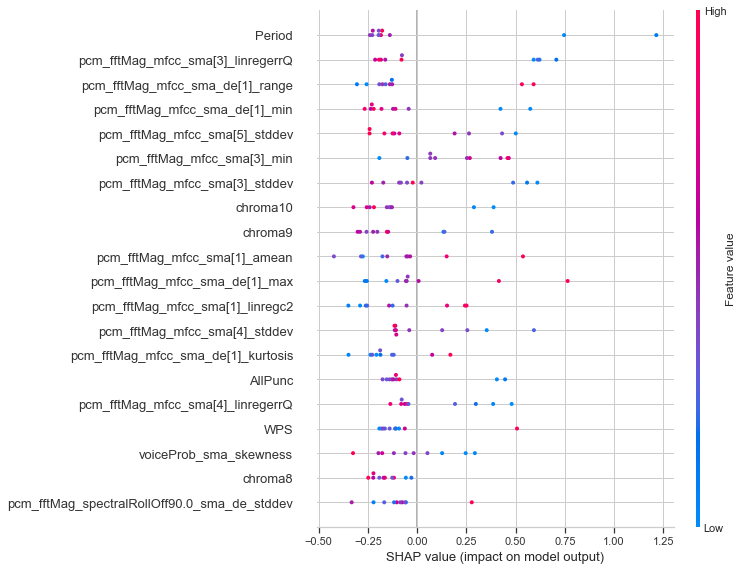

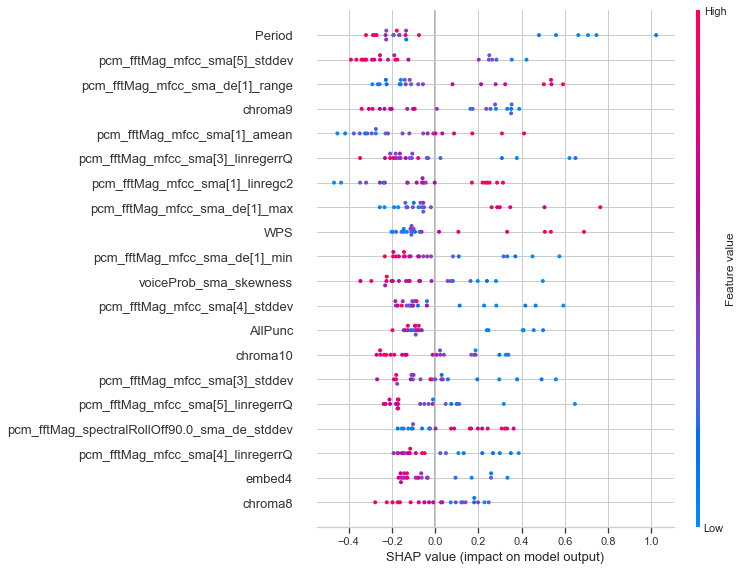

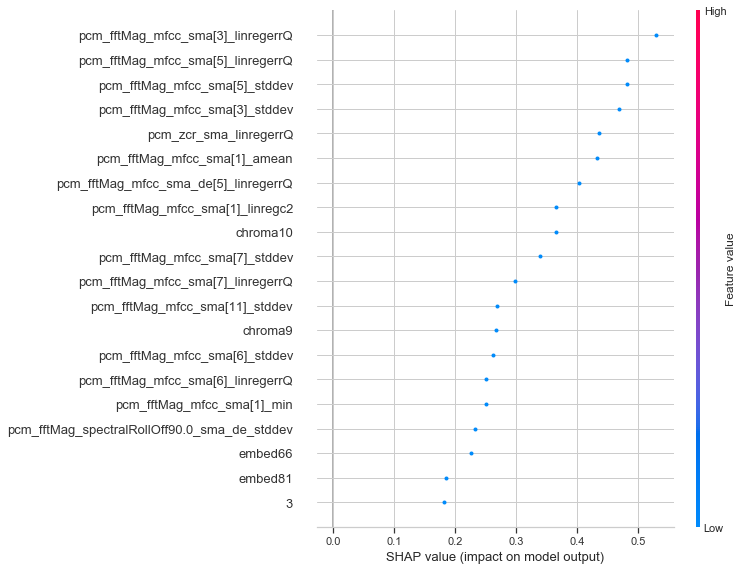

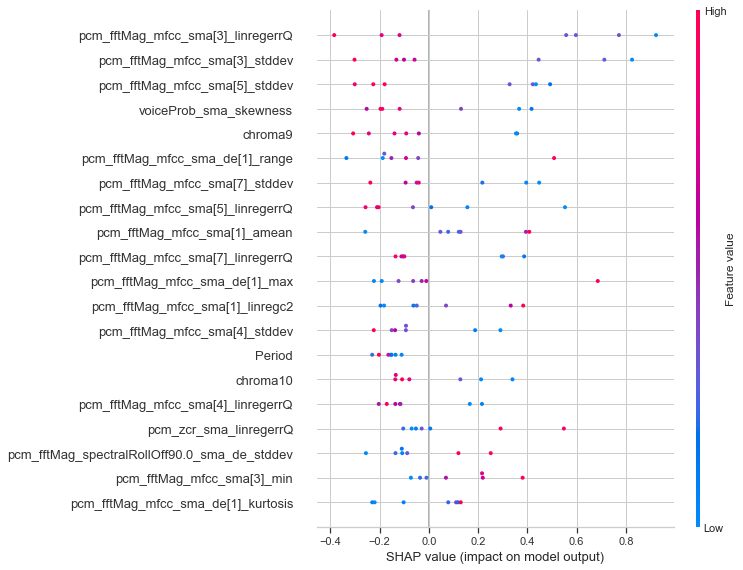

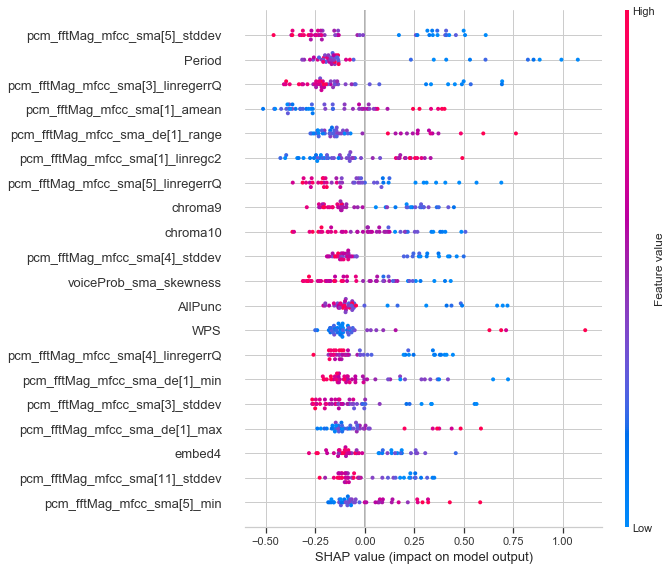

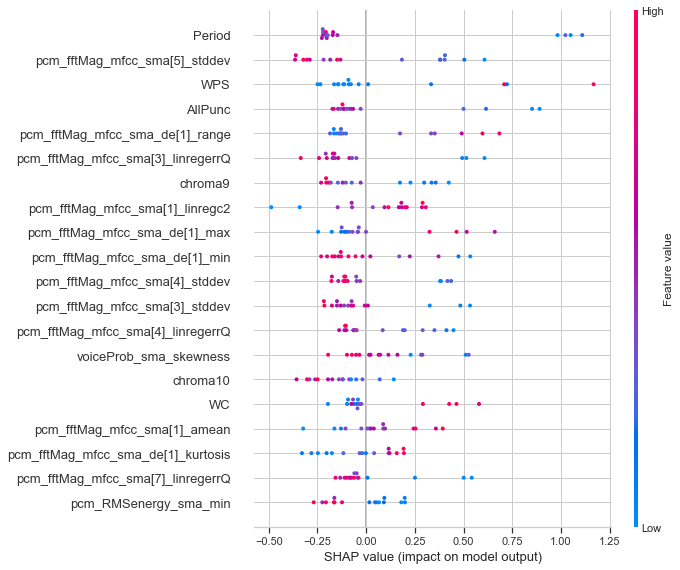

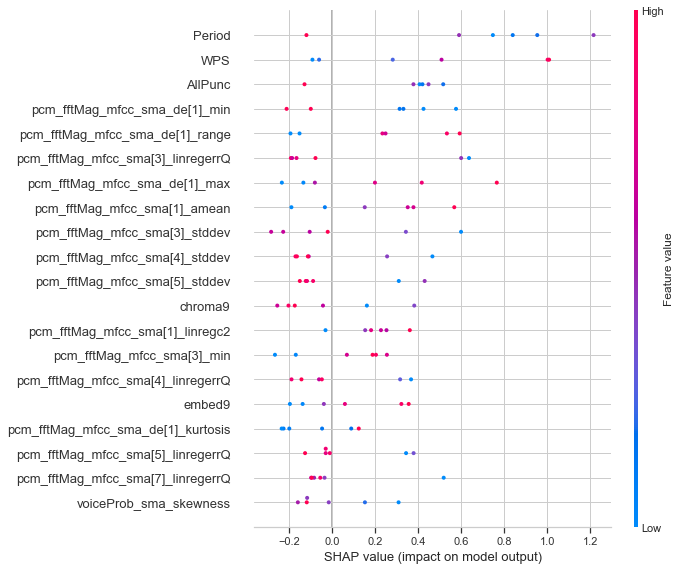

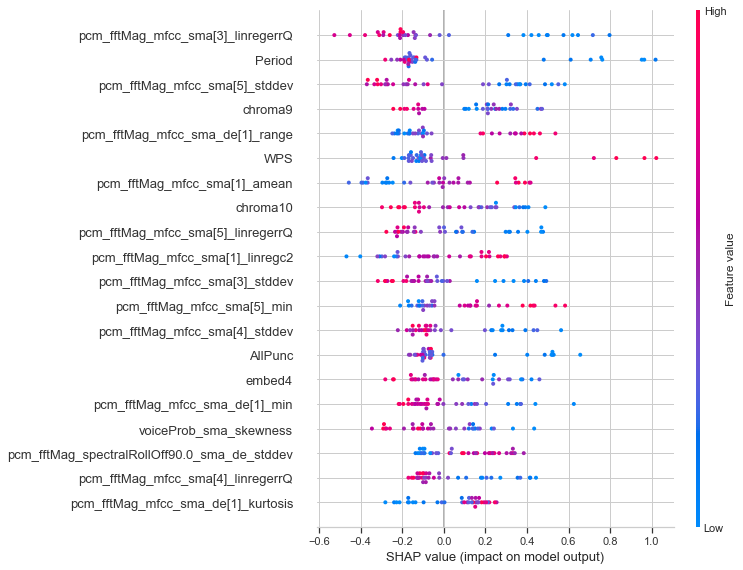

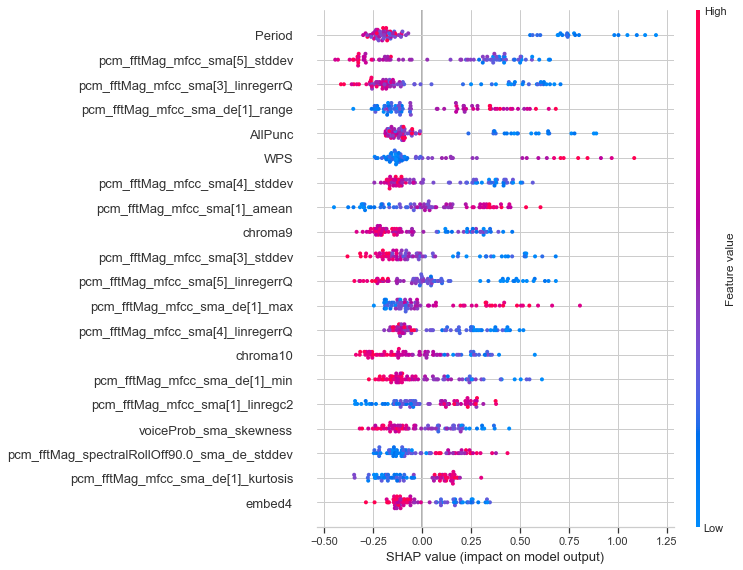

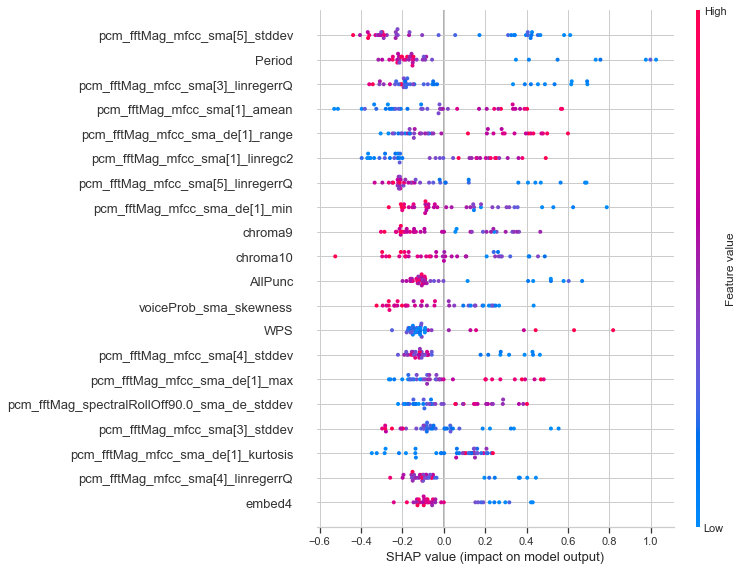

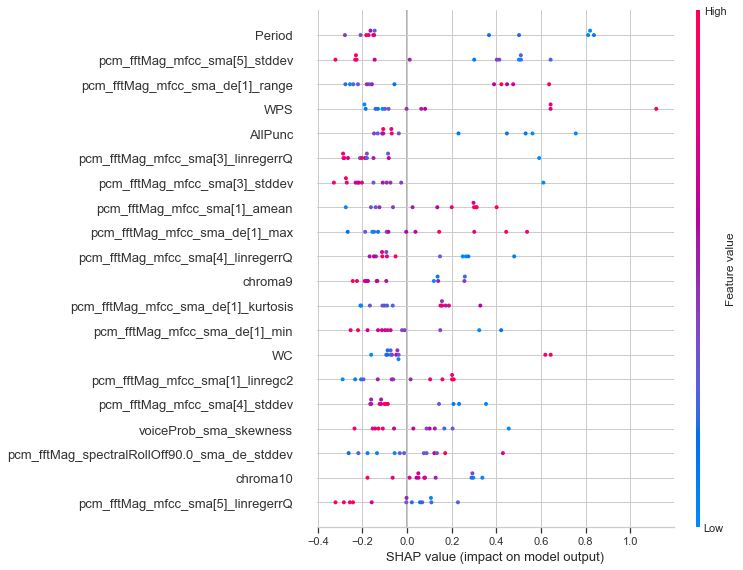

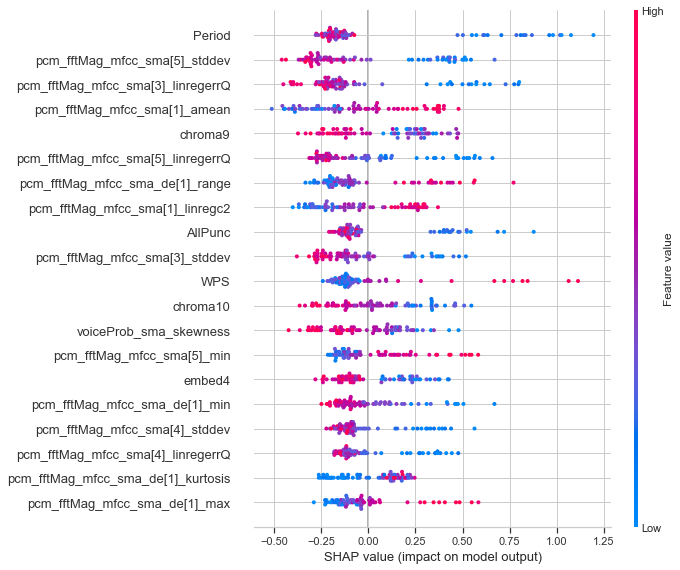

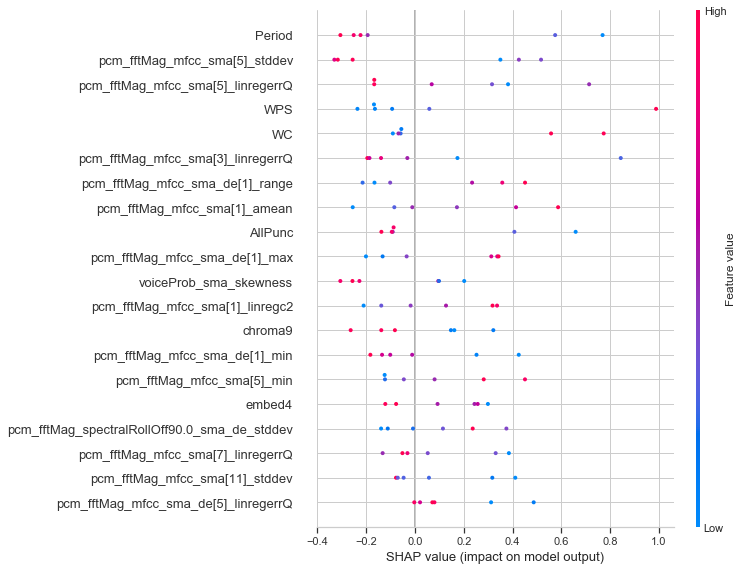

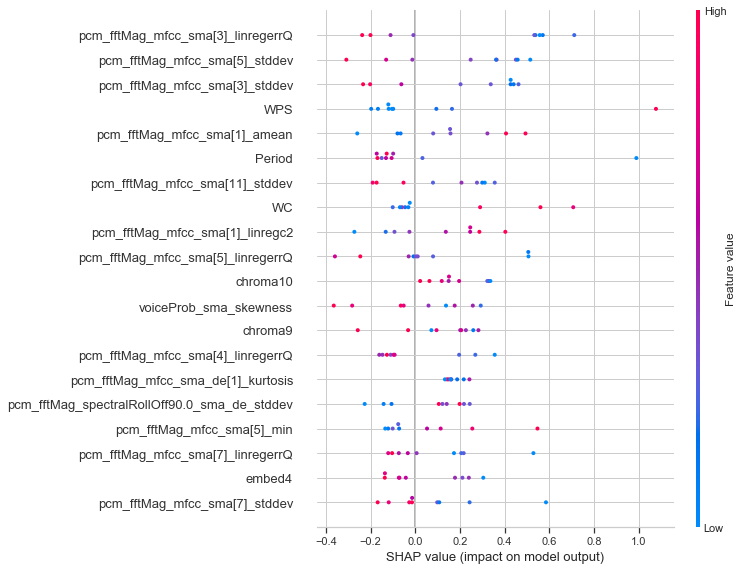

In [287]:
for g in genres:
    comedy_films = X_test_rf[X_test[g] == 1][X_train_rf.columns]
    shap.summary_plot(shap_values[(X_test[g] == 1).values], comedy_films)

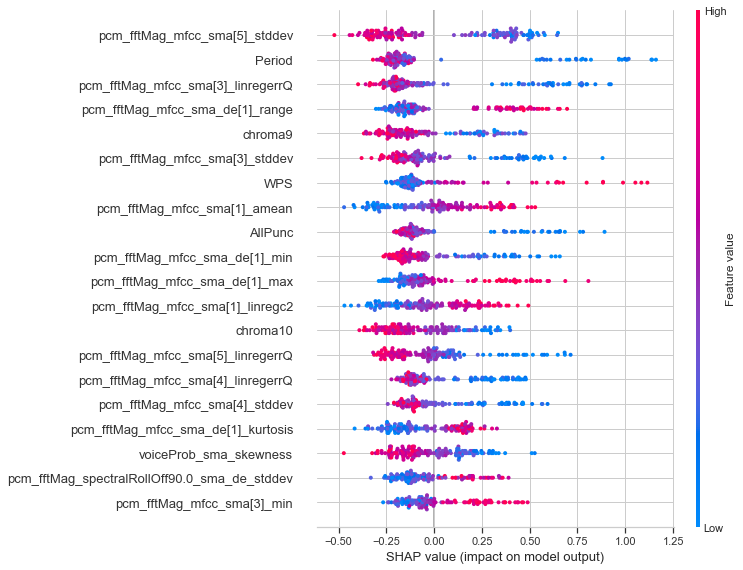

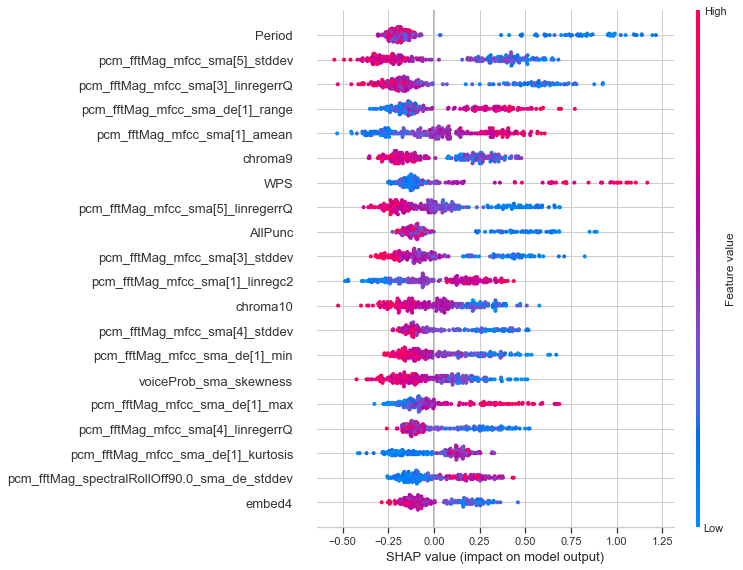

In [284]:
gen_films = X_test_rf[X_test['Comedy'] == 1][X_train_rf.columns]
shap.summary_plot(shap_values[(X_test['Comedy'] == 1).values], gen_films)

gen_films = X_test_rf[X_test['Drama'] == 1][X_train_rf.columns]
shap.summary_plot(shap_values[(X_test['Drama'] == 1).values], gen_films)

In [ ]:
comedy_films = X_test_rf[X_test['Horror'] == 1][X_train_rf.columns]
shap.summary_plot(shap_values[(X_test['Horror'] == 1).values], comedy_films)

EDA on prosodic feature variance versus quality

In [188]:
# genre_perf_df = pd.read_csv('/content/gdrive/My Drive/genre_perf_df.csv', index_col = [0])

In [197]:
y

0       66.0
1       64.0
2       68.0
3       94.0
4       61.0
        ... 
2039    49.0
2040    51.0
2041    42.0
2042    33.0
2043    23.0
Name: metascore, Length: 2044, dtype: float64

/Users/sujipark/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


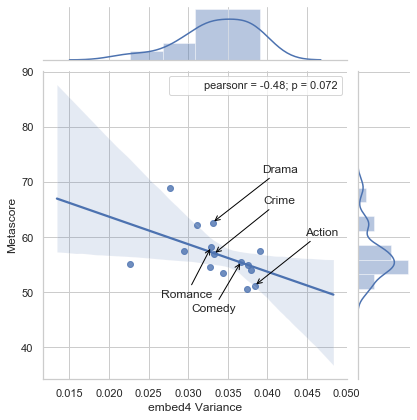

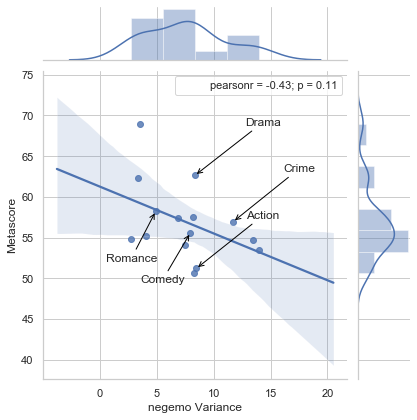

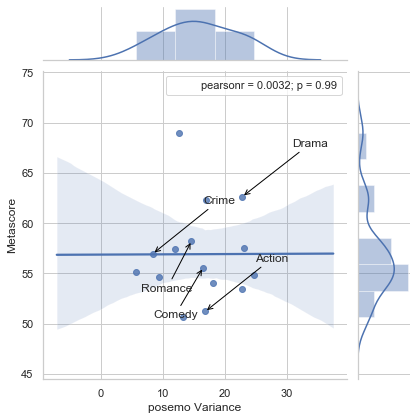

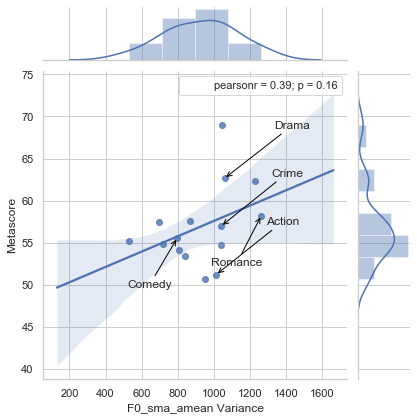

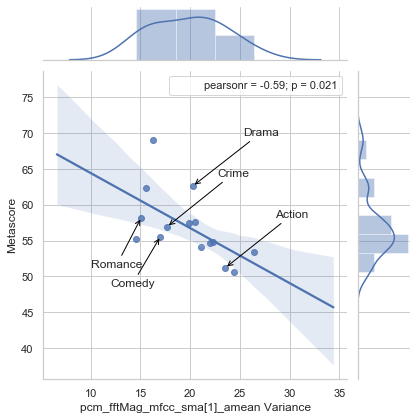

In [199]:
# ml['embed4'].plot(kind = 'kde') # normally distributed, so we can use bartlett's test
# print(bartlett(ml[ml['Drama'] == 1]['embed4'], ml[ml['Drama'] != 1]['embed4']))
# print('Drama var:', ml[ml['Drama']==1]['embed4'].var(), ',', 'Non-drama var:', ml[ml['Drama']!=1]['embed4'].var())

from scipy.stats import bartlett, pearsonr

def ann(row):
    ind = row[0]
    r = row[1]
    flip = (ind % 2 * -1 )
    if flip == 0:
      flip = 1
    plt.gca().annotate(r['Genre'], xy=(r["Variance"], r["metascore"]), 
                       xytext=(flip * 50,flip * 50),
                       textcoords ="offset points", 
                       arrowprops = {'arrowstyle': '->', 'connectionstyle':"arc3", 'color':'black'})

def plotVarianceVersusMeanRating(varname):
  # plot regression of embed4 against mean rating by genre
  xs = [ml[ml[genre] == 1][varname].var() for genre in genres]
  ys = [y[ml[ml[genre]==1].index].mean() for genre in genres]
  lmdf = pd.DataFrame([xs,ys,genres]).T
  lmdf.columns = ['Variance', 'metascore', 'Genre']
  lmdf['Variance'] = lmdf['Variance'].astype('float')
  lmdf['metascore'] = lmdf['metascore'].astype('float')
  lmdf = lmdf.set_index('Genre').loc[genre_perf_df.index].reset_index().rename(columns = {'index': 'Genre'}).head(15)
  reg = sns.jointplot('Variance', 'metascore', lmdf, kind = 'reg')
  reg.annotate(pearsonr)
  reg.set_axis_labels(varname + ' Variance', 'Metascore')
  for row in lmdf.head().iterrows():
    ann(row)
  
plotVarianceVersusMeanRating('embed4')
plotVarianceVersusMeanRating('negemo')
plotVarianceVersusMeanRating('posemo')
plotVarianceVersusMeanRating('F0_sma_amean')
plotVarianceVersusMeanRating('pcm_fftMag_mfcc_sma[1]_amean')


# Extra code below.

Code for generating features from prosodic embeddings.

```
# generate prosodic embedding features

import numpy as np
# merge in prosody embeddings and collect mean
# get all embeddings
embeddings_files = glob.glob('/content/gdrive/My Drive/prosody_embeddings/*.npy')
embeddings_dict = {}
for yt_link in final['youtubeId']:
  for f in embeddings_files:
    if yt_link in f:
      if yt_link not in embeddings_dict:
        embeddings_dict[yt_link] = []
      embeddings_dict[yt_link].append(np.load(f))

# create 1D numpy arrays by taking mean
for key in embeddings_dict:
  embeddings_dict[key] = np.mean(np.array(embeddings_dict[key]), axis = 0).flatten()

# create dataframe
prosody_df = pd.DataFrame.from_dict(embeddings_dict, orient='index')
prosody_df.columns = 'embed' + prosody_df.columns.astype(str)
prosody_df = prosody_df.rename_axis('youtubeId').reset_index()

prosody_df.to_csv('/content/gdrive/My Drive/mean_prosody_df.csv', index=False)
```

Code for feature selection using Recursive Feature Elimination

```
# train random forest
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import TfidfVectorizer

rf = RandomForestRegressor(n_estimators=100, n_jobs = -1)
selector = RFE(rf, 100, step=1)
X_train_texts = X_train["text"]
X_test_texts = X_test["text"]
rf_feature_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/rf_feature_lowlevel.csv')

X_train_rf = X_train.drop(columns = ['youtubeId', 'audio_fn','title', 'text'])
X_test_rf = X_test.drop(columns = ['youtubeId', 'audio_fn','title', 'text'])
features_keep = rf_feature_df['selected_feature_name'].tolist()
X_train_rf = X_train_rf[features_keep]
X_test_rf = X_test_rf[features_keep]
print("start")


tf_vect = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(1, 3), max_features = 100)
tf_train = tf_vect.fit_transform(X_train_texts.tolist())
tf_test = tf_vect.transform(X_test_texts.tolist())
tf_train_df = pd.DataFrame(tf_train.toarray())
X_train_rf = pd.concat([X_train_rf.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = 1)
tf_test_df = pd.DataFrame(tf_test.toarray())
X_test_rf = pd.concat([X_test_rf.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = 1)

rf = RandomForestRegressor(n_estimators=100, n_jobs = -1)


X_train_col = X_train_rf.columns.tolist()
assert X_test_rf.columns.tolist() == X_train_col
X_train_rf = selector.fit_transform(X_train_rf, y_train)
X_test_rf = selector.transform(X_test_rf)

selected_features, rank = selector.support_, selector.ranking_

from collections import deque
feature_indices = deque(sorted([i for i in range(len(selected_features)) if selected_features[i]]))

rf_feature_df = pd.DataFrame(columns = ['rank', 'feature_category', 'selected_feature_name'])
tfidf_dict = {y:x for x,y in tf_vect.vocabulary_.items()}
for best_feature_idx, r in zip(feature_indices, rank):
    feature_name = X_train_col[best_feature_idx]
    print('feature', feature_name)
    if feature_name in praat_features:
        feature_category = 'praat'
    elif feature_name in liwc_features:
        feature_category = 'liwc'
    elif feature_name in opensmile_features:
        feature_category = 'opensmile'
    elif feature_name in spectral_df:
        feature_category = 'spectral'
    elif feature_name in chroma_df:
        feature_category = 'chroma'
    elif type(feature_name) == str and 'embed' in feature_name:
        feature_category = 'prosodic_embed'
    elif feature_name in tfidf_dict.keys():
        feature_category = 'tf-idf:{}'.format(tfidf_dict[feature_name])
    else:
        feature_category = "genre"
    rf_feature_df= rf_feature_df.append(pd.Series([r, feature_category,feature_name], index=rf_feature_df.columns), ignore_index=True)

rf_feature_df.to_csv('/content/gdrive/My Drive/feature_extraction/rf_feature_select.csv')

```

```
import omdb
# must use OMDb API parameters

API_KEY='5561048d'#'b09220b1'#46063543
# if using the module level client
omdb.set_default('apikey', API_KEY)


d = {}
for imdb_id in imdb_ids:
    if imdb_id in d:
        continue
    d[imdb_id] = omdb.imdbid(imdb_id, timeout=5)
```

In [215]:
rf_feat_imp = list(feat_impts.index)

In [220]:
lm_feat = list(lm_feat)

In [221]:
lm_feat

['pcm_fftMag_mfcc_sma_de[1]_range',
 'embed19',
 16,
 'embed38',
 'pcm_fftMag_mfcc_sma[5]_min',
 'pcm_fftMag_spectralRollOff75.0_sma_de_maxPos',
 'pcm_fftMag_mfcc_sma[2]_min',
 'pcm_fftMag_spectralRollOff25.0_sma_de_amean',
 'pcm_fftMag_mfcc_sma[3]_min',
 3,
 'embed107',
 'pcm_fftMag_mfcc_sma_de[8]_maxPos',
 'pcm_fftMag_mfcc_sma[1]_amean',
 'pcm_fftMag_spectralRollOff25.0_sma_de_maxPos',
 'pcm_fftMag_mfcc_sma_de[12]_maxPos']

In [222]:
rf_feat_imp

['pcm_fftMag_mfcc_sma[3]_linregerrQ',
 'Period',
 'pcm_fftMag_mfcc_sma[5]_stddev',
 'WPS',
 'pcm_fftMag_mfcc_sma[5]_linregerrQ',
 'pcm_fftMag_mfcc_sma[1]_amean',
 'pcm_fftMag_mfcc_sma[3]_stddev',
 'pcm_fftMag_mfcc_sma_de[1]_range',
 'AllPunc',
 'pcm_fftMag_mfcc_sma_de[1]_max',
 'chroma9',
 'pcm_fftMag_mfcc_sma[1]_linregc2',
 'chroma10',
 'pcm_fftMag_mfcc_sma_de[1]_min',
 'voiceProb_sma_skewness']

In [288]:
set(lm_feat).difference(set(rf_feat_imp))

{16,
 3,
 'embed107',
 'embed19',
 'embed38',
 'pcm_fftMag_mfcc_sma[2]_min',
 'pcm_fftMag_mfcc_sma[3]_min',
 'pcm_fftMag_mfcc_sma[5]_min',
 'pcm_fftMag_mfcc_sma_de[12]_maxPos',
 'pcm_fftMag_mfcc_sma_de[8]_maxPos',
 'pcm_fftMag_spectralRollOff25.0_sma_de_amean',
 'pcm_fftMag_spectralRollOff25.0_sma_de_maxPos',
 'pcm_fftMag_spectralRollOff75.0_sma_de_maxPos'}

In [291]:
set(set(lm_feat)& set(rf_feat_imp))

{'pcm_fftMag_mfcc_sma[1]_amean', 'pcm_fftMag_mfcc_sma_de[1]_range'}

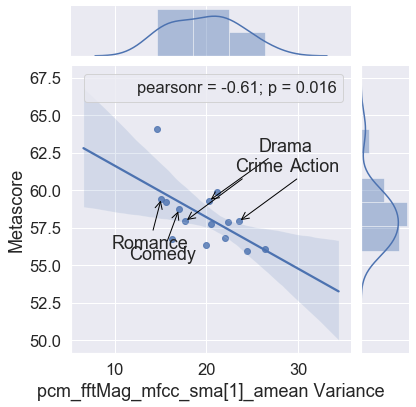

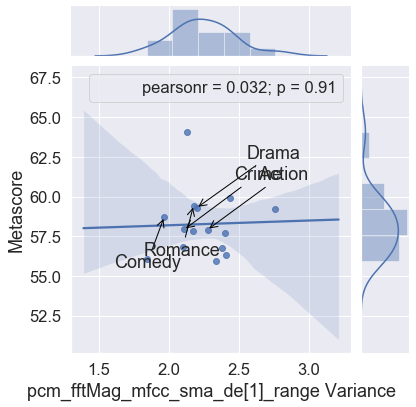

In [305]:
# for x in rf_feat_imp:
#     plotVarianceVersusMeanRating(x)
sns.set(font_scale=1.5)
for x in set(set(lm_feat)& set(rf_feat_imp)):
    plotVarianceVersusMeanRating(x)


In [306]:
# AMONG P_val >= 0.05


# % slight positive:mfcc range(none)

# % strong negative: n-gram
# % slight negative spectral rolloff maxpos, mfcc min,  mfcc maxpos, 


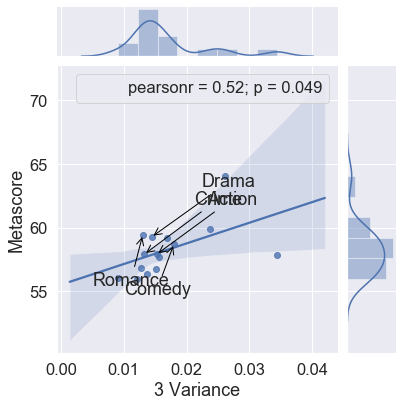

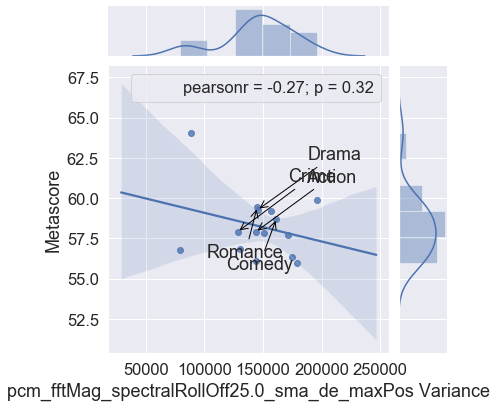

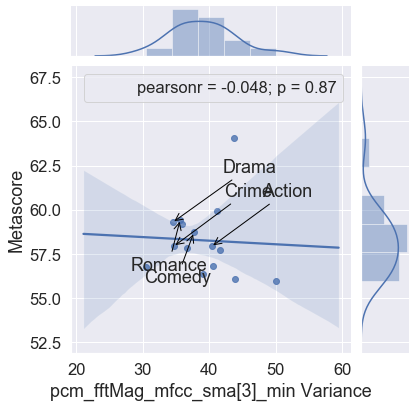

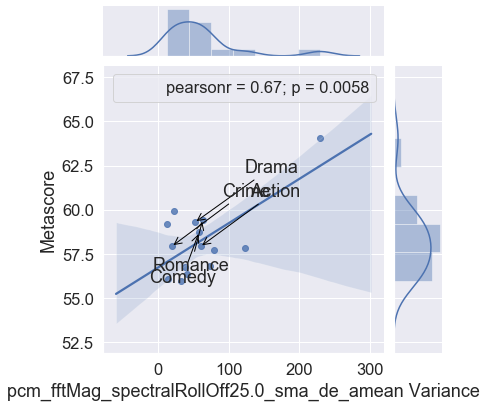

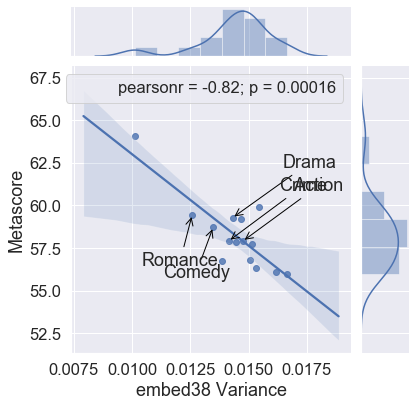

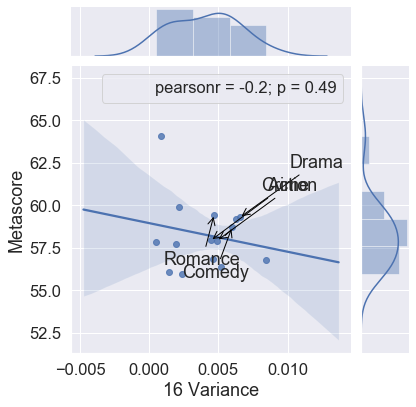

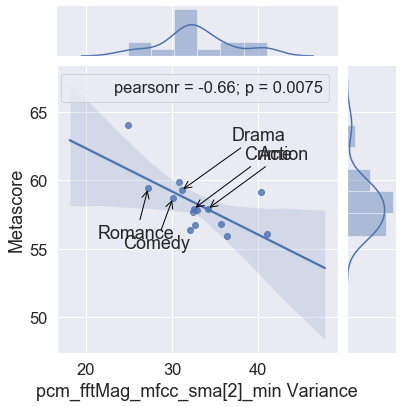

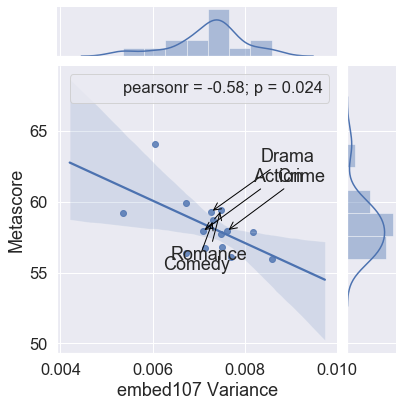

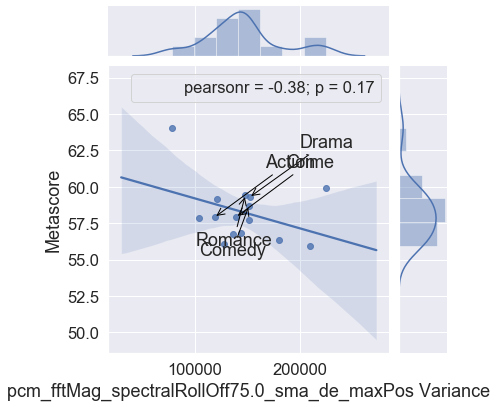

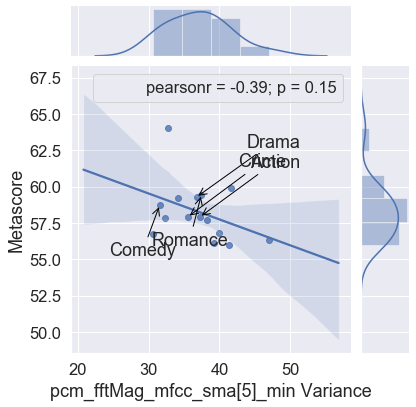

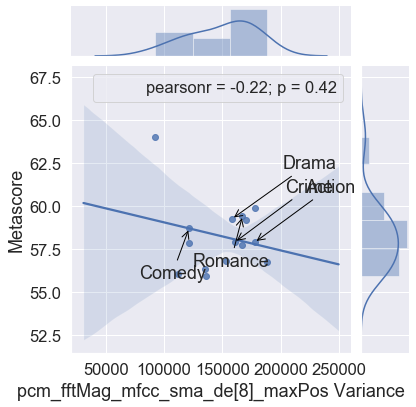

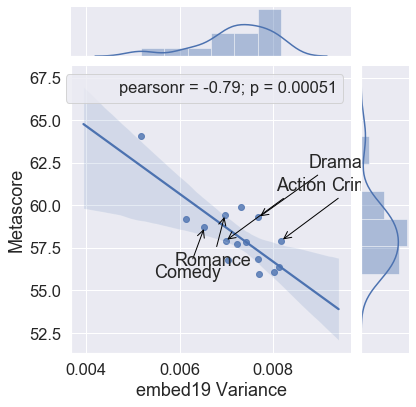

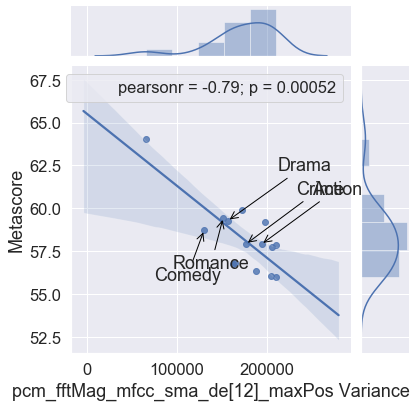

In [307]:
for x in set(lm_feat).difference(set(rf_feat_imp)):
    plotVarianceVersusMeanRating(x)
# common features

In [267]:
# ml['embed4'].plot(kind = 'kde') # normally distributed, so we can use bartlett's test
# print(bartlett(ml[ml['Drama'] == 1]['embed4'], ml[ml['Drama'] != 1]['embed4']))
# print('Drama var:', ml[ml['Drama']==1]['embed4'].var(), ',', 'Non-drama var:', ml[ml['Drama']!=1]['embed4'].var())

from scipy.stats import bartlett, pearsonr

def ann(row):
    ind = row[0]
    r = row[1]
    flip = (ind % 2 * -1 )
    if flip == 0:
      flip = 1
    plt.gca().annotate(r['Genre'], xy=(r["Variance"], r["metascore"]), 
                       xytext=(flip * 50,flip * 50),
                       textcoords ="offset points", 
                       arrowprops = {'arrowstyle': '->', 'connectionstyle':"arc3", 'color':'black'})

def plotVarianceVersusMeanRating(varname):
  # plot regression of embed4 against mean rating by genre
  xs = [merged[merged[genre] == 1][varname].var() for genre in genres]
  ys = [y[merged[merged[genre]==1].index].mean() for genre in genres]
  lmdf = pd.DataFrame([xs,ys,genres]).T
  lmdf.columns = ['Variance', 'metascore', 'Genre']
  lmdf['Variance'] = lmdf['Variance'].astype('float')
  lmdf['metascore'] = lmdf['metascore'].astype('float')
  lmdf = lmdf.set_index('Genre').loc[genre_perf_df.index].reset_index().rename(columns = {'index': 'Genre'}).head(15)
  reg = sns.jointplot('Variance', 'metascore', lmdf, kind = 'reg')
  reg.annotate(pearsonr)
  reg.set_axis_labels(str(varname) + ' Variance', 'Metascore')
  for row in lmdf.head().iterrows():
    ann(row)
  
# plotVarianceVersusMeanRating('embed4')
# plotVarianceVersusMeanRating('negemo')
# plotVarianceVersusMeanRating('posemo')
# plotVarianceVersusMeanRating('F0_sma_amean')
# plotVarianceVersusMeanRating('pcm_fftMag_mfcc_sma[1]_amean')


In [254]:
merged = pd.merge(combined_rf, ml)

In [255]:
len(merged)

2044